# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## >> Objective of Starbucks Capstone Project 

### What type of offers should starbucks create ?
### and which customers should they distribute to ?
### to make most amount of money $$



In short understanding demand and customer base

# 1. Data Understanding

In [1]:
import pandas as pd
import numpy as np
import math
import json
import sys
import datetime
import matplotlib.pyplot as plt 

#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio

In [2]:
#Having a glance at all the portfolio data. Small and easy !
#import sns
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


**portfolio**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
#Glancing at the data types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


## Profile

In [4]:
#Profile dataset is compact. Lets see how is income distributed
#profile.head(5)
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


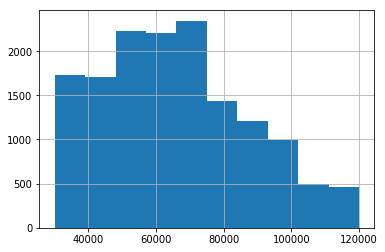

In [5]:
# Income is right skewed
profile['income'].hist();

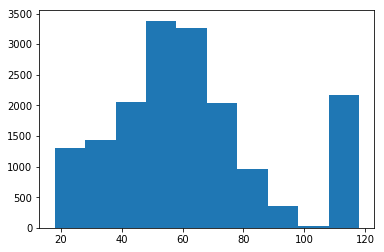

In [6]:
#Age is slightly right skewed and some outliers towards the right corner
plt.hist(profile['age'], bins=10);

In [7]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

**profile**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [8]:
#Seems like gender and income have some null values
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


## Transcript

In [9]:
#Transcript dataset has all transactions to and by a customer
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
#Good that no value here is null
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**transcript**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [11]:
#Understanding how often each event occurs in transcript
transcript.groupby('event').size()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
dtype: int64

# Data Processing

## 2a. profile data processing

In [12]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
#renaming id to person
profile = profile.rename(columns={'id':'person'})

#checking if person column has duplicate values
boolean = not profile["person"].is_unique      # True (credit to @Carsten)
boolean = profile['person'].duplicated().any()
boolean

False

In [14]:
#changing type of columns
profile['age'] = profile['age'].astype(int)

In [15]:
profile = profile.reindex(columns=['person', 'age', 'gender', 'became_member_on', 'income'])

In [16]:
profile.head(2)

,person,age,gender,became_member_on,income
0,68be06ca386d4c31939f3a4f0e3dd783,118,None,20170212,NaN
1,0610b486422d4921ae7d2bf64640c50b,55,F,20170715,112000.0


In [17]:
#Removing age 118 as it looks like some system error. I will be happy to live at that age though :=)
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

In [18]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
person              17000 non-null object
age                 14825 non-null float64
gender              14825 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 664.1+ KB


In [19]:
profile[['age','income']] = profile[['age','income']].astype('int', errors='ignore')

In [20]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['member_since'] = profile['became_member_on'].dt.year
profile['member_duration'] = datetime.datetime.today().date() - profile['became_member_on'].dt.date
profile['member_duration'] = profile['member_duration'].dt.days

In [21]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
person              17000 non-null object
age                 14825 non-null float64
gender              14825 non-null object
became_member_on    17000 non-null datetime64[ns]
income              14825 non-null float64
member_since        17000 non-null int64
member_duration     17000 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 929.8+ KB


In [22]:
profile.head(5)

,person,age,gender,became_member_on,income,member_since,member_duration
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,None,2017-02-12,NaN,2017,1798
1,0610b486422d4921ae7d2bf64640c50b,55.0,F,2017-07-15,112000.0,2017,1645
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,None,2018-07-12,NaN,2018,1283
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,F,2017-05-09,100000.0,2017,1712
4,a03223e636434f42ac4c3df47e8bac43,NaN,None,2017-08-04,NaN,2017,1625


## 2b. Portfolio dataframe processing

In [23]:
#Changing id to offer_id
portfolio = portfolio.rename(columns={'id':'offer_id'})

#Extracting channels into other columns as 0's and 1's
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [24]:
portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


## 2c. transcript dataframe processing

In [25]:
# First we need to check what values are there in the value column
values = []
for idx, row in transcript.iterrows():
    for v in row['value']:
        if v in values:
            continue
        else:
            values.append(v)

In [26]:
values

['offer id', 'amount', 'offer_id', 'reward']

In [27]:
#create new columns with datatypes
transcript['offer_id'] = '' # str
transcript['amount'] = 0  # int
transcript['reward'] = 0  # int

In [28]:
for idx, row in transcript.iterrows():
    for v in row['value']:
        if v == 'offer_id' or v == 'offer id':
            transcript.at[idx, 'offer_id'] = row['value'][v]
        if v == 'amount':
            transcript.at[idx, 'amount'] = row['value'][v]
        if v == 'reward':
            transcript.at[idx, 'reward'] = row['value'][v]

In [29]:
# filling all the NaNs in the 'offer_id' column with 'N/A' values (i.e. Not Applicable)
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

In [30]:
# dropping the 'value' column 
transcript.drop('value', axis=1, inplace=True)

In [31]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [32]:
transcript.head(5)

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


## 2d - Joining Transcript to Profile and then to Portfolio

In [33]:
df_all = transcript.merge(profile, on='person', how='left')

In [34]:
df_all = df_all.merge(portfolio, on='offer_id', how='left')

In [35]:
#This is the final single table that will be used for all our analysis
df_all.head(5)

,event,person,time,offer_id,amount,reward_x,age,gender,became_member_on,income,member_since,member_duration,difficulty,duration,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75.0,F,2017-05-09,100000.0,2017,1712,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,NaN,None,2017-08-04,NaN,2017,1625,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,68.0,M,2018-04-26,70000.0,2018,1360,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,NaN,None,2017-09-25,NaN,2017,1573,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,NaN,None,2017-10-02,NaN,2017,1566,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [36]:
#Changing Float to Int datatypes of some columns where it makes sense
df_all[['difficulty', 'duration','channel_email','channel_mobile','channel_social','channel_web','reward_y']] = df_all[['difficulty', 'duration','channel_email','channel_mobile','channel_social','channel_web','reward_y']].astype('int', errors='ignore')

In [37]:
transcript.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', 'N/A'], dtype=object)

In [38]:
df_all.head(5)

,event,person,time,offer_id,amount,reward_x,age,gender,became_member_on,income,member_since,member_duration,difficulty,duration,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75.0,F,2017-05-09,100000.0,2017,1712,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,NaN,None,2017-08-04,NaN,2017,1625,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,68.0,M,2018-04-26,70000.0,2018,1360,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,NaN,None,2017-09-25,NaN,2017,1573,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,NaN,None,2017-10-02,NaN,2017,1566,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [39]:
#checking column types of merged table
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
offer_id            306534 non-null object
amount              306534 non-null int64
reward_x            306534 non-null int64
age                 272762 non-null float64
gender              272762 non-null object
became_member_on    306534 non-null datetime64[ns]
income              272762 non-null float64
member_since        306534 non-null int64
member_duration     306534 non-null int64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward_y            167581 non-null float64
channel_email       167581 non-null float64
channel_mobile      167581 non-null float64
channel_social      167581 non-null float64
channel_web         167581 non-null float64
dtypes: datetime6

In [40]:
df_all['age_group'] = pd.cut(df_all['age'], bins=[17, 35, 55, 103],
                labels=['young-adulthood', 'middle-age', 'older-adulthood'])

In [41]:
df_all.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

In [42]:
df_all['income_group'] = pd.cut(df_all['income'], bins=[0, 48000, 78000, 120000],
                labels=['low', 'mid', 'high'])

In [43]:
df_all.head(5)

,event,person,time,offer_id,amount,reward_x,age,gender,became_member_on,income,...,difficulty,duration,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web,age_group,income_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75.0,F,2017-05-09,100000.0,...,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,older-adulthood,high
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,NaN,None,2017-08-04,NaN,...,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,68.0,M,2018-04-26,70000.0,...,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,older-adulthood,mid
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,NaN,None,2017-09-25,NaN,...,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,NaN,None,2017-10-02,NaN,...,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,NaN,NaN


# 3. Analysis

## 3a. Which age group views most offers

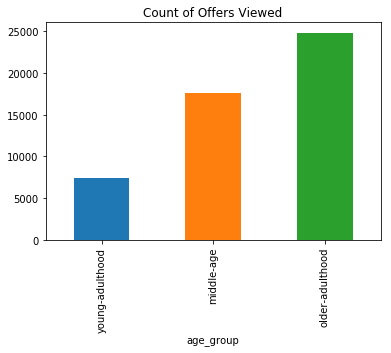

In [44]:
count_vals = df_all[df_all['event'] == 'offer viewed'].groupby('age_group').size()

(count_vals[:10]).plot(kind="bar");
plt.title("Count of Offers Viewed");

### Women have overall a higher income than men

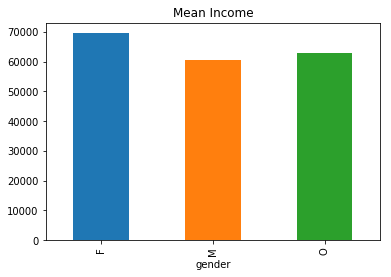

In [49]:
#Gender with Income Range
count_vals = df_all.groupby('gender')['income'].mean()

(count_vals[:10]).plot(kind="bar");
plt.title("Mean Income");

## 3b. What Offer to send to which customer

In [50]:
# First taking a subset of combined data
df_all[['offer_id','event','age_group','income_group','gender','channel_email','channel_mobile','channel_social','channel_web']].head(5)

,offer_id,event,age_group,income_group,gender,channel_email,channel_mobile,channel_social,channel_web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,older-adulthood,high,F,1.0,1.0,0.0,1.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,NaN,NaN,None,1.0,0.0,0.0,1.0
2,2906b810c7d4411798c6938adc9daaa5,offer received,older-adulthood,mid,M,1.0,1.0,0.0,1.0
3,fafdcd668e3743c1bb461111dcafc2a4,offer received,NaN,NaN,None,1.0,1.0,1.0,1.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,NaN,NaN,None,1.0,1.0,1.0,1.0


In [51]:
# To the core it seems since values are simulated its hard to form patterns anywhere 
# So probably using machine learning algorithms doesn't make sense as there is no bias

df_all[df_all['event'] == 'offer viewed'].groupby(['gender','offer_id']).sum()[['channel_email','channel_mobile','channel_social','channel_web']]

channel_email  channel_mobile  \
gender offer_id                                                          
F      0b1e1539f2cc45b7b9fa7c272da2e1d7          982.0             0.0   
       2298d6c36e964ae4a3e7e9706d1fb8c2         2614.0          2614.0   
       2906b810c7d4411798c6938adc9daaa5         1529.0          1529.0   
       3f207df678b143eea3cee63160fa8bed         1515.0          1515.0   
       4d5c57ea9a6940dd891ad53e9dbe8da0         2623.0          2623.0   
       5a8bc65990b245e5a138643cd4eb9837         2395.0          2395.0   
       9b98b8c7a33c4b65b9aebfe6a799e6d9         1544.0          1544.0   
       ae264e3637204a6fb9bb56bc8210ddfd         2364.0          2364.0   
       f19421c1d4aa40978ebb69ca19b0e20d         2612.0          2612.0   
       fafdcd668e3743c1bb461111dcafc2a4         2608.0          2608.0   
M      0b1e1539f2cc45b7b9fa7c272da2e1d7         1179.0             0.0   
       2298d6c36e964ae4a3e7e9706d1fb8c2         3675.0          3675.0   
       2906b810c7d4411798c6938adc9daaa5         1866.0          1866.0   
       3f207df678b143eea3cee63160fa8bed         1902.0          1902.0   
       4d5c57ea9a6940dd891ad53e9dbe8da0         3635.0          3635.0   
       5a8bc65990b245e5a138643cd4eb9837         3387.0          3387.0   
       9b98b8c7a33c4b65b9aebfe6a799e6d9         1879.0          1879.0   
       ae264e3637204a6fb9bb56bc8210ddfd         3454.0          3454.0   
       f19421c1d4aa40978ebb69ca19b0e20d         3613.0          3613.0   
       fafdcd668e3743c1bb461111dcafc2a4         3711.0          3711.0   
O      0b1e1539f2cc45b7b9fa7c272da2e1d7           54.0             0.0   
       2298d6c36e964ae4a3e7e9706d1fb8c2           90.0            90.0   
       2906b810c7d4411798c6938adc9daaa5           65.0            65.0   
       3f207df678b143eea3cee63160fa8bed           70.0            70.0   
       4d5c57ea9a6940dd891ad53e9dbe8da0           71.0            71.0   
       5a8bc65990b245e5a138643cd4eb9837           91.0            91.0   
       9b98b8c7a33c4b65b9aebfe6a799e6d9           76.0            76.0   
       ae264e3637204a6fb9bb56bc8210ddfd           83.0            83.0   
       f19421c1d4aa40978ebb69ca19b0e20d           85.0            85.0   
       fafdcd668e3743c1bb461111dcafc2a4           88.0            88.0   

                                         channel_social  channel_web  
gender offer_id                                                       
F      0b1e1539f2cc45b7b9fa7c272da2e1d7             0.0        982.0  
       2298d6c36e964ae4a3e7e9706d1fb8c2          2614.0       2614.0  
       2906b810c7d4411798c6938adc9daaa5             0.0       1529.0  
       3f207df678b143eea3cee63160fa8bed             0.0       1515.0  
       4d5c57ea9a6940dd891ad53e9dbe8da0          2623.0       2623.0  
       5a8bc65990b245e5a138643cd4eb9837          2395.0          0.0  
       9b98b8c7a33c4b65b9aebfe6a799e6d9             0.0       1544.0  
       ae264e3637204a6fb9bb56bc8210ddfd          2364.0          0.0  
       f19421c1d4aa40978ebb69ca19b0e20d          2612.0       2612.0  
       fafdcd668e3743c1bb461111dcafc2a4          2608.0       2608.0  
M      0b1e1539f2cc45b7b9fa7c272da2e1d7             0.0       1179.0  
       2298d6c36e964ae4a3e7e9706d1fb8c2          3675.0       3675.0  
       2906b810c7d4411798c6938adc9daaa5             0.0       1866.0  
       3f207df678b143eea3cee63160fa8bed             0.0       1902.0  
       4d5c57ea9a6940dd891ad53e9dbe8da0          3635.0       3635.0  
       5a8bc65990b245e5a138643cd4eb9837          3387.0          0.0  
       9b98b8c7a33c4b65b9aebfe6a799e6d9             0.0       1879.0  
       ae264e3637204a6fb9bb56bc8210ddfd          3454.0          0.0  
       f19421c1d4aa40978ebb69ca19b0e20d          3613.0       3613.0  
       fafdcd668e3743c1bb461111dcafc2a4          3711.0       3711.0  
O      0b1e1539f2cc45b7b9fa7c272da2e1d7             0.0         54.0  
       2298d6c36e964ae4a3e7e9706d1fb8c2

### Since we cannot differenciate on channels lets try another feature

In [52]:
# Women have higher income than men
df_all.groupby(['gender','income_group']).size()

gender  income_group
F       low             20967
        mid             54448
        high            37686
M       low             47570
        mid             81059
        high            27061
O       low               973
        mid              2023
        high              975
dtype: int64

In [53]:
# Most of the transaction money comes from older adult groups
df_all[df_all['event'] == 'transaction'].groupby(['gender','income_group','age_group']).sum()['amount']

gender  income_group  age_group      
F       low           young-adulthood     26989.0
                      middle-age          24535.0
                      older-adulthood     35137.0
        mid           young-adulthood     51562.0
                      middle-age         132450.0
                      older-adulthood    183746.0
        high          young-adulthood         NaN
                      middle-age         115130.0
                      older-adulthood    269738.0
M       low           young-adulthood     44782.0
                      middle-age          43693.0
                      older-adulthood     44301.0
        mid           young-adulthood     65726.0
                      middle-age         156438.0
                      older-adulthood    176591.0
        high          young-adulthood         NaN
                      middle-age          90860.0
                      older-adulthood    186769.0
O       low           young-adulthood       948.0
            

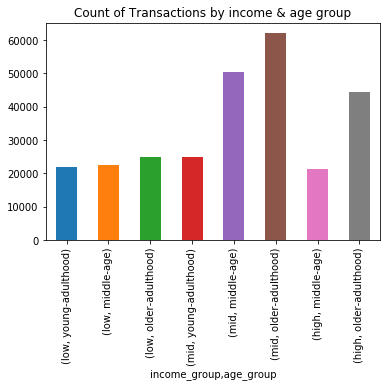

In [54]:
count_vals = df_all.groupby(['income_group','age_group']).size()

(count_vals[:10]).plot(kind="bar");
plt.title("Count of Transactions by income & age group");

### Older Adulthood age group (56 and above) account for most of the high income group
### >> Let's focus on 'older-adulthood' age group and 'high' income group

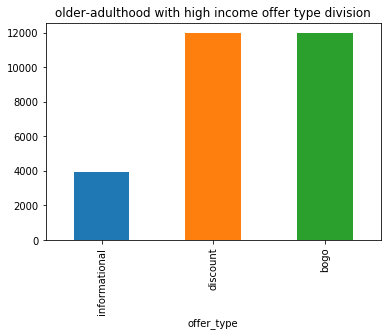

In [55]:
count_vals = df_all[(df_all['age_group'] == 'older-adulthood') & (df_all['income_group'] == 'high')].groupby('offer_type').size().sort_values()

(count_vals[:10]).plot(kind="bar");
plt.title("older-adulthood with high income offer type division");

### Bogo and Discount offer types are well recieved

### Lets see which channels older and high income people use

In [56]:
df_all[(df_all['age_group'] == 'older-adulthood') & 
       (df_all['income_group'] == 'high')].groupby(['offer_id','offer_type']).sum()[['channel_email','channel_mobile','channel_social','channel_web']]

,,channel_email,channel_mobile,channel_social,channel_web
offer_id,offer_type,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,2599.0,0.0,0.0,2599.0
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3299.0,3299.0,3299.0,3299.0
2906b810c7d4411798c6938adc9daaa5,discount,2734.0,2734.0,0.0,2734.0
3f207df678b143eea3cee63160fa8bed,informational,1826.0,1826.0,0.0,1826.0
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,3060.0,3060.0,3060.0,3060.0
5a8bc65990b245e5a138643cd4eb9837,informational,2100.0,2100.0,2100.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2670.0,2670.0,0.0,2670.0
ae264e3637204a6fb9bb56bc8210ddfd,bogo,3082.0,3082.0,3082.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,bogo,3163.0,3163.0,3163.0,3163.0


### Channel Social and Channel Web are slightly less used than others

## >> Result <<

### Create more Discount and Bogo offer types to Older Adult population (56 and above) with high income (78000 and above) and distribute them on all the channels 